In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import json
import time
import scipy.stats as st
from scipy.stats import linregress

### Data organization process

In [2]:
# Study data files
fire_data_path = 'Resources/California_Fire_Incidents.csv'
ca_county_path = 'Resources/County_CA.csv'

# Read in csv file
fire_df = pd.read_csv(fire_data_path)
ca_county_df = pd.read_csv(ca_county_path)

# Combine the data into a single dataset
merged_fire_df = pd.merge(ca_county_df, fire_df, how='left', left_on = 'Counties', right_on = 'Counties')
merged_fire_df.head()

,Counties,AcresBurned,Active,AdminUnit,AirTankers,ArchiveYear,CalFireIncident,CanonicalUrl,ConditionStatement,ControlStatement,...,Started,Time.1,Status,StructuresDamaged,StructuresDestroyed,StructuresEvacuated,StructuresThreatened,UniqueId,Updated,WaterTenders
0,Alameda,240.0,False,CAL FIRE Santa Clara Unit,NaN,2013.0,True,/incidents/2013/6/8/vasco-fire/,NaN,NaN,...,6/8/13,10:16:00Z,Finalized,NaN,NaN,NaN,NaN,2ad509e4-99f1-4e1a-81eb-839f772f9c45,2013-06-08T13:25:00Z,NaN
1,Alameda,150.0,False,CAL FIRE Santa Clara Unit,NaN,2013.0,True,/incidents/2013/10/4/highland-fire/,NaN,NaN,...,10/4/13,07:35:00Z,Finalized,NaN,NaN,NaN,NaN,6a48000a-6198-46dd-9a91-0b0159183145,2013-10-04T10:30:00Z,NaN
2,Alameda,50.0,False,CAL FIRE Santa Clara Unit,NaN,2013.0,True,/incidents/2013/7/4/grant-fire/,NaN,NaN,...,7/4/13,10:00:00Z,Finalized,NaN,NaN,NaN,NaN,07fb8b11-f39b-4cd0-8a27-2d4fef7fe680,2013-07-04T11:30:00Z,NaN
3,Alameda,38.0,False,CAL FIRE Santa Clara Unit / Alameda County Fire,NaN,2013.0,True,/incidents/2013/7/6/fallon-fire/,NaN,NaN,...,7/6/13,13:09:00Z,Finalized,NaN,NaN,NaN,NaN,4c04a4e5-f580-4e62-bb53-2575c72d29dc,2013-07-06T14:30:00Z,NaN
4,Alameda,2700.0,False,CAL FIRE Santa Clara Unit,NaN,2015.0,True,/incidents/2015/8/19/tesla-fire/,Unit is now in control of incident.,NaN,...,8/19/15,14:45:00Z,Finalized,NaN,NaN,NaN,NaN,8fc920eb-ca45-4d77-9a92-1326eca602d6,2015-08-22T18:30:00Z,1.0


In [3]:
# Clean data
ca_fire_df = merged_fire_df.drop(columns=[
    "Active", 
    "CanonicalUrl", 
    "ConditionStatement", 
    "FuelType", 
    "Location", 
    "ControlStatement", 
    "CalFireIncident", 
    "AdminUnit", 
    "PercentContained", 
    "Time.1", 
    "Time", 
    "Status", 
    "SearchDescription", 
    "SearchKeywords", 
    "Public", 
    "Updated"], inplace=False)

# Get only month data in each row
fire_start = ca_fire_df['Started']
fire_start_list = list(fire_start)
months = []

for d in range(len(fire_start_list)):
    try:
        date = fire_start_list[d].split('/')
        month = date[0]
        months.append(str(month))
    except:
        months.append(None)

ca_fire_df['Started Month'] = months

# Converting dtypes
ca_fire_df['ArchiveYear'] = ca_fire_df['ArchiveYear'].map('{:.0f}'.format)

# Store clean data in csv file
ca_fire_df.to_csv('output_data/california_fire_cleaned.csv', index=False, header=True)
ca_fire_df.head()

,Counties,AcresBurned,AirTankers,ArchiveYear,CountyIds,CrewsInvolved,Dozers,Engines,Extinguished,Days Burned,...,Name,PersonnelInvolved,Started,StructuresDamaged,StructuresDestroyed,StructuresEvacuated,StructuresThreatened,UniqueId,WaterTenders,Started Month
0,Alameda,240.0,NaN,2013,1,NaN,NaN,NaN,6/8/13,0.0,...,Vasco Fire,NaN,6/8/13,NaN,NaN,NaN,NaN,2ad509e4-99f1-4e1a-81eb-839f772f9c45,NaN,6
1,Alameda,150.0,NaN,2013,1,NaN,NaN,NaN,10/4/13,0.0,...,Highland Fire,NaN,10/4/13,NaN,NaN,NaN,NaN,6a48000a-6198-46dd-9a91-0b0159183145,NaN,10
2,Alameda,50.0,NaN,2013,1,NaN,NaN,NaN,7/4/13,0.0,...,Grant Fire,NaN,7/4/13,NaN,NaN,NaN,NaN,07fb8b11-f39b-4cd0-8a27-2d4fef7fe680,NaN,7
3,Alameda,38.0,NaN,2013,1,NaN,NaN,NaN,7/6/13,0.0,...,Fallon Fire,NaN,7/6/13,NaN,NaN,NaN,NaN,4c04a4e5-f580-4e62-bb53-2575c72d29dc,NaN,7
4,Alameda,2700.0,NaN,2015,1,NaN,NaN,5.0,8/22/15,3.0,...,Tesla Fire,18.0,8/19/15,NaN,NaN,NaN,NaN,8fc920eb-ca45-4d77-9a92-1326eca602d6,1.0,8


**Major fire incidents**

*Burned area more than 10 arces*

In [12]:
# Major fire incident
major_fire_df = ca_fire_df.loc[ca_fire_df['AcresBurned']>=10]

# Store clean data in csv file
major_fire_df.to_csv('output_data/major_fire.csv', index=False, header=True)
major_fire_df

,Counties,AcresBurned,AirTankers,ArchiveYear,CountyIds,CrewsInvolved,Dozers,Engines,Extinguished,Days Burned,...,Name,PersonnelInvolved,Started,StructuresDamaged,StructuresDestroyed,StructuresEvacuated,StructuresThreatened,UniqueId,WaterTenders,Started Month
0,Alameda,240.0,NaN,2013,1,NaN,NaN,NaN,6/8/13,0.0,...,Vasco Fire,NaN,6/8/13,NaN,NaN,NaN,NaN,2ad509e4-99f1-4e1a-81eb-839f772f9c45,NaN,6
1,Alameda,150.0,NaN,2013,1,NaN,NaN,NaN,10/4/13,0.0,...,Highland Fire,NaN,10/4/13,NaN,NaN,NaN,NaN,6a48000a-6198-46dd-9a91-0b0159183145,NaN,10
2,Alameda,50.0,NaN,2013,1,NaN,NaN,NaN,7/4/13,0.0,...,Grant Fire,NaN,7/4/13,NaN,NaN,NaN,NaN,07fb8b11-f39b-4cd0-8a27-2d4fef7fe680,NaN,7
3,Alameda,38.0,NaN,2013,1,NaN,NaN,NaN,7/6/13,0.0,...,Fallon Fire,NaN,7/6/13,NaN,NaN,NaN,NaN,4c04a4e5-f580-4e62-bb53-2575c72d29dc,NaN,7
4,Alameda,2700.0,NaN,2015,1,NaN,NaN,5.0,8/22/15,3.0,...,Tesla Fire,18.0,8/19/15,NaN,NaN,NaN,NaN,8fc920eb-ca45-4d77-9a92-1326eca602d6,1.0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1629,Yuba,10.0,NaN,2017,58,NaN,NaN,NaN,1/9/18,225.0,...,Twenty Fire,NaN,5/29/17,NaN,NaN,NaN,NaN,67d31514-620f-49d1-b4bd-a3a92efd48ca,NaN,5
1630,Yuba,80.0,NaN,2019,58,NaN,NaN,NaN,6/25/19,0.0,...,Scott Fire,NaN,6/25/19,NaN,NaN,NaN,NaN,31cbc968-6d9d-412b-8bc3-6846ca398fe2,NaN,6
1631,Yuba,80.0,NaN,2019,58,NaN,NaN,NaN,6/24/19,0.0,...,Scott Fire,NaN,6/24/19,NaN,NaN,NaN,NaN,937f9f26-8d23-4ee7-a0f3-61313dcc63f3,NaN,6
1632,Yuba,70.0,NaN,2019,58,NaN,NaN,NaN,6/17/19,9.0,...,Levee Fire,NaN,6/8/19,NaN,NaN,NaN,NaN,3fd43a39-4e82-4b7e-a642-be86b5c73522,NaN,6


## Pyres California Summary

### All fire incidents

In [157]:
# Calculation
fire_burn_count = ca_fire_df.groupby('Counties')['UniqueId'].count()
fire_injuries_fatalities = ca_fire_df.groupby('Counties').agg({"Fatalities":'sum',"Injuries":'sum'}).sum(axis=1)
fire_mean = ca_fire_df.groupby('Counties')['AcresBurned'].mean()
fire_median = ca_fire_df.groupby('Counties')['AcresBurned'].median()
fire_variance = ca_fire_df.groupby('Counties')['AcresBurned'].var()
fire_standard_dv = ca_fire_df.groupby('Counties')['AcresBurned'].std()
fire_sem = ca_fire_df.groupby('Counties')['AcresBurned'].sem()

# Create a dataframe to hold the result
fire_summary_df = pd.DataFrame({"No. of Incidents": fire_burn_count,
                                "No. of Injuries&Fatalities": fire_injuries_fatalities,
                                "Acres Burned Mean": fire_mean, 
                                "Acres Burned Median": fire_median, 
                                "Acres Burned VAR": fire_variance, 
                                "Acres Burned STD": fire_standard_dv,
                                "Acres Burned SEM": fire_sem
                                })
                                    
# Give the displayed data cleaner formatting
fire_summary_df["Acres Burned Mean"] = fire_summary_df["Acres Burned Mean"].map('{:,.2f}'.format)
fire_summary_df["Acres Burned Median"] = fire_summary_df["Acres Burned Median"].map('{:,.2f}'.format)
fire_summary_df["Acres Burned STD"] = fire_summary_df["Acres Burned STD"].map('{:,.2f}'.format)
fire_summary_df["Acres Burned SEM"] = fire_summary_df["Acres Burned SEM"].map('{:,.2f}'.format)

# Present data
fire_summary_df.head()

,No. of Incidents,No. of Injuries&Fatalities,Acres Burned Mean,Acres Burned Median,Acres Burned VAR,Acres Burned STD,Acres Burned SEM
Counties,,,,,,,
Alameda,32,0.0,199.59,46.50,2.292581e+05,478.81,84.64
Alpine,2,0.0,0.00,0.00,0.000000e+00,0.00,0.00
Amador,13,3.0,483.46,60.00,1.328712e+06,"1,152.70",319.70
Butte,66,108.0,"2,889.42",89.50,3.559001e+08,"18,865.31","2,322.16"
Calaveras,22,4.0,120.36,81.50,1.406196e+04,118.58,25.28


                 No. of Incidents
Counties                         
Riverside                     146
San Diego                      89
Butte                          66
Shasta                         64
San Luis Obispo                64
Kern                           62
Siskiyou                       57
Fresno                         57
San Bernardino                 53
Tehama                         51


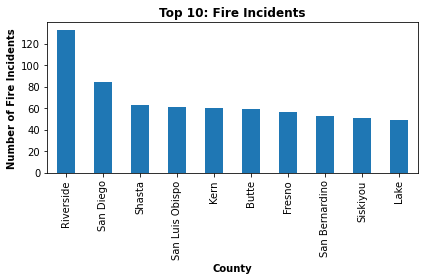

In [165]:
#Top ten counties for all fire incidents
all_top_10_df = fire_summary_df.sort_values(by='No. of Incidents', ascending=False)
all_top_ten_counties = all_top_10_df[['No. of Incidents']].head(10)

# Generate a bar plot
all_top10_bar = top_ten_counties.plot(kind="bar", legend=False)

# Set x/y label, title
all_top10_bar.set_title(label='Top 10: Fire Incidents', fontweight = 'bold')
all_top10_bar.set_xlabel('County', fontweight = 'bold')
all_top10_bar.set_ylabel('Number of Fire Incidents', fontweight = 'bold')

# Save bar graph to Images folder
plt.tight_layout()
top10_bar.figure.savefig('Images/bar_top_ca_all_fire.png')

# Present the bar chart with data
print(all_top_ten_counties)
plt.show()

# To close pyplot
plt.close()

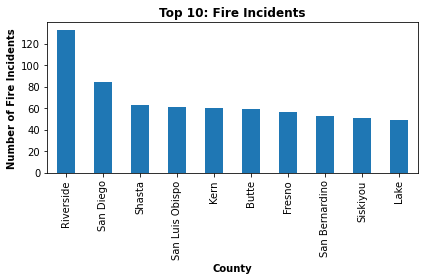

In [182]:
#Top ten counties for all fire incidents (area burned)
all_top_ten_area_df = ca_fire_df.sort_values(['AcresBurned'],ascending=False).groupby('Counties')
all_top_ten_area_counties = all_top_ten_area_df['AcresBurned'].head(10)

# Generate a bar plot
all_top_ten_area_counties_bar = top_ten_counties.plot(kind="bar", legend=False)

# Set x/y label, title
all_top_ten_area_counties_bar.set_title(label='Top 10: Fire Incidents', fontweight = 'bold')
all_top_ten_area_counties_bar.set_xlabel('County', fontweight = 'bold')
all_top_ten_area_counties_bar.set_ylabel('Number of Fire Incidents', fontweight = 'bold')

# Save bar graph to Images folder
plt.tight_layout()
all_top_ten_area_counties_bar.figure.savefig('Images/bar_top_ca_all_fire.png')

# Present the bar chart with data
# print(all_top_ten_area_df.head(10))
plt.show()

# To close pyplot
plt.close()

               No. of Incidents
Counties                       
San Francisco                 0
Imperial                      0
Alpine                        2
Sierra                        2
Sutter                        3
San Mateo                     3
Santa Cruz                    4
Kings                         5
Marin                         6
Colusa                        6


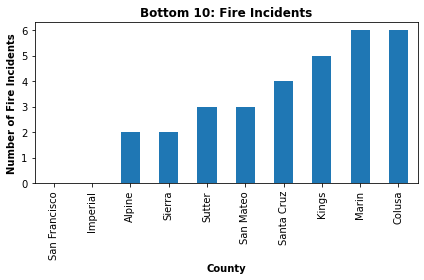

In [161]:
#Top ten counties for all fire incidents
all_bottom_10_df = fire_summary_df.sort_values(by='No. of Incidents', ascending=True)
all_bottom_ten_counties = all_bottom_10_df[['No. of Incidents']].head(10)

# Generate a bar plot
all_bottom10_bar = all_bottom_ten_counties.plot(kind="bar", legend=False)

# Set x/y label, title
all_bottom10_bar.set_title(label='Bottom 10: Fire Incidents', fontweight = 'bold')
all_bottom10_bar.set_xlabel('County', fontweight = 'bold')
all_bottom10_bar.set_ylabel('Number of Fire Incidents', fontweight = 'bold')

# Save bar graph to Images folder
plt.tight_layout()
top10_bar.figure.savefig('Images/bar_bottom_ca_all_fire.png')

# Present the bar chart with data
print(all_bottom_ten_counties)
plt.show()

# To close pyplot
plt.close()

### Major fire incidents 

In [162]:
# Calculation
mj_burn_count = major_fire_df.groupby('Counties')['UniqueId'].count()
mj_injuries_fatalities = major_fire_df.groupby('Counties').agg({"Fatalities":'sum',
                                                             "Injuries":'sum'}).sum(axis=1)
mj_burn_mean = major_fire_df.groupby('Counties')['AcresBurned'].mean()
mj_burn_median = major_fire_df.groupby('Counties')['AcresBurned'].median()
mj_burn_variance = major_fire_df.groupby('Counties')['AcresBurned'].var()
mj_burn_standard_dv = major_fire_df.groupby('Counties')['AcresBurned'].std()
mj_burn_sem = major_fire_df.groupby('Counties')['AcresBurned'].sem()

# Create a dataframe to hold the result
mj_burn_summary_df = pd.DataFrame({"No. of Incidents": mj_burn_count,
                                   "No. of Injuries&Fatalities": mj_injuries_fatalities,
                                   "Acres Burned Mean": mj_burn_mean, 
                                   "Acres Burned Median": mj_burn_median, 
                                   "Acres Burned VAR": mj_burn_variance, 
                                   "Acres Burned STD": mj_burn_standard_dv,
                                   "Acres Burned SEM": mj_burn_sem
                                  })
                                    
# Give the displayed data cleaner formatting
mj_burn_summary_df["Acres Burned Mean"] = mj_burn_summary_df["Acres Burned Mean"].map('{:,.2f}'.format)
mj_burn_summary_df["Acres Burned Median"] = mj_burn_summary_df["Acres Burned Median"].map('{:,.2f}'.format)
mj_burn_summary_df["Acres Burned STD"] = mj_burn_summary_df["Acres Burned STD"].map('{:,.2f}'.format)
mj_burn_summary_df["Acres Burned SEM"] = mj_burn_summary_df["Acres Burned SEM"].map('{:,.2f}'.format)

# Present data
mj_burn_summary_df.head()

,No. of Incidents,No. of Injuries&Fatalities,Acres Burned Mean,Acres Burned Median,Acres Burned VAR,Acres Burned STD,Acres Burned SEM
Counties,,,,,,,
Alameda,32,0.0,199.59,46.50,2.292581e+05,478.81,84.64
Amador,11,2.0,569.55,96.00,1.541470e+06,"1,241.56",374.34
Butte,59,108.0,"3,231.39",103.00,3.977319e+08,"19,943.22","2,596.39"
Calaveras,22,4.0,120.36,81.50,1.406196e+04,118.58,25.28
Colusa,6,4.0,"76,552.67",72.50,2.709956e+10,"164,619.45","67,205.61"


                 No. of Incidents
Counties                         
Riverside                     133
San Diego                      84
Shasta                         63
San Luis Obispo                61
Kern                           60
Butte                          59
Fresno                         56
San Bernardino                 53
Siskiyou                       51
Lake                           49


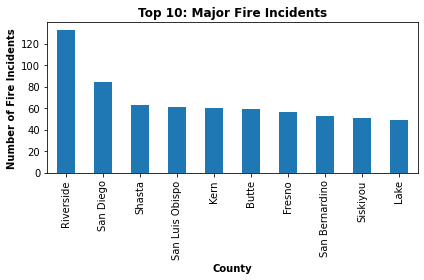

In [163]:
#Top ten counties for major fire incidents
mj_top_10_df = mj_burn_summary_df.sort_values(by='No. of Incidents', ascending=False)
mj_top_ten_counties = top_10_df[['No. of Incidents']].head(10)

# Generate a bar plot
mj_top10_bar = top_ten_counties.plot(kind="bar", legend=False)

# Set x/y label, title
mj_top10_bar.set_title(label='Top 10: Major Fire Incidents', fontweight = 'bold')
mj_top10_bar.set_xlabel('County', fontweight = 'bold')
mj_top10_bar.set_ylabel('Number of Fire Incidents', fontweight = 'bold')

# Save bar graph to Images folder
plt.tight_layout()
mj_top10_bar.figure.savefig('Images/bar_top_ca_mj_fire.png')

# Present the bar chart with data
print(mj_top_ten_counties)
plt.show()

# To close pyplot
plt.close()

             No. of Incidents
Counties                     
Sierra                      2
Santa Cruz                  2
Sutter                      3
San Mateo                   3
Kings                       5
Marin                       6
Colusa                      6
Del Norte                   6
Glenn                       7
San Joaquin                 8


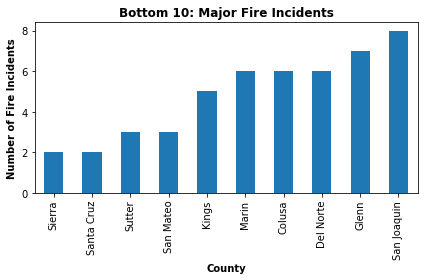

In [164]:
# Find last ten counties for major fire incidents
mj_bottom_10_df = mj_burn_summary_df.sort_values(by='No. of Incidents', ascending=True)
mj_last_ten_counties = bottom_10_df[['No. of Incidents']].head(10)


# Generate a bar plot
mj_bottom10_bar = last_ten_counties.plot(kind="bar", legend=False)

# Set x/y label, title
mj_bottom10_bar.set_title(label='Bottom 10: Major Fire Incidents', fontweight = 'bold')
mj_bottom10_bar.set_xlabel('County', fontweight = 'bold')
mj_bottom10_bar.set_ylabel('Number of Fire Incidents', fontweight = 'bold')

# Save bar graph to Images folder
plt.tight_layout()
mj_top10_bar.figure.savefig('Images/bar_bottom_ca_mj_fire.png')

# Present the bar chart with data
print(last_ten_counties)
plt.show()

# To close pyplot
plt.close()

In [5]:
# Duplicated data removed process
final_burned_df = major_fire_df.drop_duplicates(subset=['UniqueId', 'Days Burned','AcresBurned'])
final_burned_df.head()

,Counties,AcresBurned,AirTankers,ArchiveYear,CountyIds,CrewsInvolved,Dozers,Engines,Extinguished,Days Burned,...,Name,PersonnelInvolved,Started,StructuresDamaged,StructuresDestroyed,StructuresEvacuated,StructuresThreatened,UniqueId,WaterTenders,Started Month
0,Alameda,240.0,NaN,2013,1,NaN,NaN,NaN,6/8/13,0.0,...,Vasco Fire,NaN,6/8/13,NaN,NaN,NaN,NaN,2ad509e4-99f1-4e1a-81eb-839f772f9c45,NaN,6
1,Alameda,150.0,NaN,2013,1,NaN,NaN,NaN,10/4/13,0.0,...,Highland Fire,NaN,10/4/13,NaN,NaN,NaN,NaN,6a48000a-6198-46dd-9a91-0b0159183145,NaN,10
2,Alameda,50.0,NaN,2013,1,NaN,NaN,NaN,7/4/13,0.0,...,Grant Fire,NaN,7/4/13,NaN,NaN,NaN,NaN,07fb8b11-f39b-4cd0-8a27-2d4fef7fe680,NaN,7
3,Alameda,38.0,NaN,2013,1,NaN,NaN,NaN,7/6/13,0.0,...,Fallon Fire,NaN,7/6/13,NaN,NaN,NaN,NaN,4c04a4e5-f580-4e62-bb53-2575c72d29dc,NaN,7
4,Alameda,2700.0,NaN,2015,1,NaN,NaN,5.0,8/22/15,3.0,...,Tesla Fire,18.0,8/19/15,NaN,NaN,NaN,NaN,8fc920eb-ca45-4d77-9a92-1326eca602d6,1.0,8


In [16]:
# Drop Null from column of interest (resources: personnel involved, dozers, engines, water tenders)
per_inv_df = final_burned_df.dropna(how='any', subset=['PersonnelInvolved'])
dozers_df = final_burned_df.dropna(how='any', subset=['Dozers'])
eng_df = final_burned_df.dropna(how='any', subset=['Engines'])
water_df = final_burned_df.dropna(how='any', subset=['WaterTenders'])

### Correlation between Final Size Burned (acres) vs Time Burned (days)

To find out that size burned area increases when time burned increases

The correlation between burned area (acres) and burned days is 0.05918
The r-squared is: 0.003502208


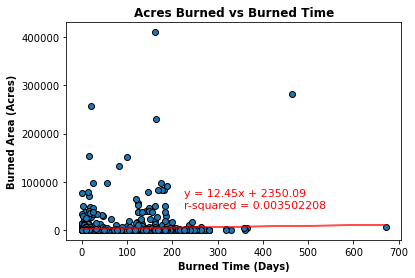

In [17]:
# Get data from dataframe to plot
area = final_burned_df.loc[(final_burned_df['Days Burned']>=0) & (final_burned_df['Days Burned']<1000), 'AcresBurned']
days = final_burned_df.loc[(final_burned_df['Days Burned']>=0) & (final_burned_df['Days Burned']<1000), 'Days Burned']

# Define x,y values
area_x_values = days
area_y_values = area

# Calculate the correlation
area_correlation = round(st.pearsonr(area_x_values, area_y_values)[0],5)
print(f"The correlation between burned area (acres) and burned days is {area_correlation}")

# Calculate linear regression values
(area_slope, area_intercept, area_rvalue, area_pvalue, area_stderr) = st.linregress(area_x_values, area_y_values)

# Calculate r-squared
area_r_squared = round(area_rvalue**2,9)
print(f"The r-squared is: {area_r_squared}")

# y = mx + b
area_regress_values = area_x_values * area_slope + area_intercept
area_line_eq = "y = " + str(round(area_slope,2)) + "x + " + str(round(area_intercept,2))

# Gernerate scatter chart with liner regression line, equation of line, r-squared value
plt.scatter(area_x_values, area_y_values, edgecolors='black')
plt.plot(area_x_values,area_regress_values, color='r', alpha=0.7)

# Plot the Annotation in the graph 
plt.annotate(area_line_eq,(225,70000), fontsize=11, color="red")
plt.annotate(f'r-squared = {area_r_squared}', (225,45000), fontsize=11, color="red")

# Define title and x/y labels
plt.title('Acres Burned vs Burned Time', fontweight='bold')
plt.xlabel('Burned Time (Days)', fontweight='bold')
plt.ylabel('Burned Area (Acres)', fontweight='bold')

# Save box plot graph to Images folder
plt.savefig('Images/day_area.png')

# Present the box plot chart
plt.show()

# To close pyplot
plt.close()

### Correlation between Resources vs Burned Time

To find out how many resources required to shorten burned time

#### Resources: Personnel Involved

The correlation between burned time (days) and personnel involved is 0.05
The r-squared is: 0.00228


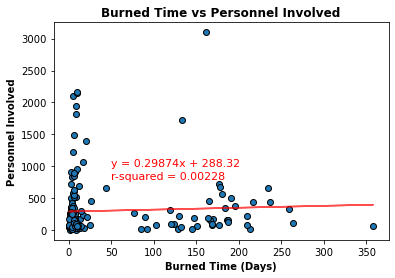

In [21]:
# Get data from dataframe to plot
per_inv_t = per_inv_df.loc[(per_inv_df['Days Burned']>=0) & (per_inv_df['Days Burned']<1000), 'PersonnelInvolved']
pt_days = per_inv_df.loc[(per_inv_df['Days Burned']>=0) & (per_inv_df['Days Burned']<1000), 'Days Burned']

# Define x, y values
pt_x_values = pt_days
pt_y_values = per_inv_t

# Calculate the correlation
pt_correlation = round(st.pearsonr(pt_x_values, pt_y_values)[0],2)
print(f"The correlation between burned time (days) and personnel involved is {pt_correlation}")

# Calculate linear regression values
(pt_slope, pt_intercept, pt_rvalue, pt_pvalue, pt_stderr) = st.linregress(pt_x_values, pt_y_values) 
                                                                                                   
# Calculate r-squared
pt_r_squared = round(pt_rvalue**2,5)
print(f"The r-squared is: {pt_r_squared}")

# y = mx + b
pt_regress_values = pt_x_values * pt_slope + pt_intercept
pt_line_eq = "y = " + str(round(pt_slope,5)) + "x + " + str(round(pt_intercept,2))

# Gernerate scatter chart with liner regression line, equation of line, r-squared value
plt.scatter(pt_x_values, pt_y_values, edgecolors='black')
plt.plot(pt_x_values,pt_regress_values, color='r', alpha=0.7)

# Plot the Annotation in the graph 
plt.annotate(pt_line_eq,(50,1000), fontsize=11, color="red")
plt.annotate(f'r-squared = {pt_r_squared}', (50,800), fontsize=11, color="red")

# Define title and x/y labels
plt.title('Burned Time vs Personnel Involved', fontweight='bold')
plt.xlabel('Burned Time (Days)', fontweight='bold')
plt.ylabel('Personnel Involved', fontweight='bold')

# Save box plot graph to Images folder
plt.savefig('Images/time_perinv.png')

# Present the box plot chart
plt.show()

# To close pyplot
plt.close()

#### Resources: Dozers

The correlation between burned time (days) and dozers is 0.07
The r-squared is: 0.0


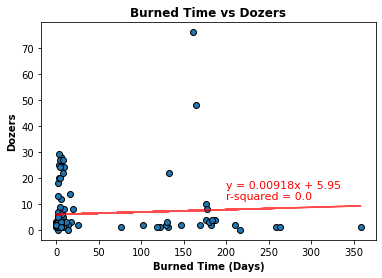

In [25]:
#Discover wheather dozers has relation to burned time
dozers_t = dozers_df.loc[(dozers_df['Days Burned']>=0) & (dozers_df['Days Burned']<1000), 'Dozers']
dt_days = dozers_df.loc[(dozers_df['Days Burned']>=0) & (dozers_df['Days Burned']<1000), 'Days Burned']

# Define x, y values
dt_x_values = dt_days
dt_y_values = dozers_t

# Calculate the correlation
dt_correlation = round(st.pearsonr(dt_x_values, dt_y_values)[0],2)
print(f"The correlation between burned time (days) and dozers is {dt_correlation}")

# Calculate linear regression values
(dt_slope, dt_intercept, dt_rvalue, dt_pvalue, dt_stderr) = st.linregress(dt_x_values, dt_y_values) 
                                                                                                   
# Calculate r-squared
dt_r_squared = round(dt_rvalue**2,2)
print(f"The r-squared is: {dt_r_squared}")

# y = mx + b
dt_regress_values = dt_x_values * dt_slope + dt_intercept
dt_line_eq = "y = " + str(round(dt_slope,5)) + "x + " + str(round(dt_intercept,2))

# Gernerate scatter chart with liner regression line, equation of line, r-squared value
plt.scatter(dt_x_values, dt_y_values, edgecolors='black')
plt.plot(dt_x_values, dt_regress_values, color='r', alpha=0.7)

# Plot the Annotation in the graph 
plt.annotate(dt_line_eq,(200,16), fontsize=11, color="red")
plt.annotate(f'r-squared = {dt_r_squared}', (200,12), fontsize=11, color="red")

# Define title and x/y labels
plt.title('Burned Time vs Dozers', fontweight='bold')
plt.xlabel('Burned Time (Days)', fontweight='bold')
plt.ylabel('Dozers', fontweight='bold')

# Save box plot graph to Images folder
plt.savefig('Images/time_dozers.png')

# Present the box plot chart
plt.show()

# To close pyplot
plt.close()

#### Resources: Engines

The correlation between burned time (days) and dozers is 0.07
The r-squared is: 0.00431


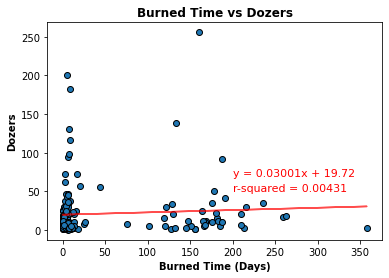

In [30]:
#Discover wheather dozers has relation to burned time
eng_t = eng_df.loc[(eng_df['Days Burned']>=0) & (eng_df['Days Burned']<1000), 'Engines']
et_days = eng_df.loc[(eng_df['Days Burned']>=0) & (eng_df['Days Burned']<1000), 'Days Burned']

# Define x, y values
et_x_values = et_days
et_y_values = eng_t

# Calculate the correlation
et_correlation = round(st.pearsonr(et_x_values, et_y_values)[0],2)
print(f"The correlation between burned time (days) and dozers is {et_correlation}")

# Calculate linear regression values
(et_slope, et_intercept, et_rvalue, et_pvalue, et_stderr) = st.linregress(et_x_values, et_y_values) 
                                                                                                   
# Calculate r-squared
et_r_squared = round(et_rvalue**2,5)
print(f"The r-squared is: {et_r_squared}")

# y = mx + b
et_regress_values = et_x_values * et_slope + et_intercept
et_line_eq = "y = " + str(round(et_slope,5)) + "x + " + str(round(et_intercept,2))

# Gernerate scatter chart with liner regression line, equation of line, r-squared value
plt.scatter(et_x_values, et_y_values, edgecolors='black')
plt.plot(et_x_values, et_regress_values, color='r', alpha=0.7)

# Plot the Annotation in the graph 
plt.annotate(et_line_eq,(200,70), fontsize=11, color="red")
plt.annotate(f'r-squared = {et_r_squared}', (200,50), fontsize=11, color="red")

# Define title and x/y labels
plt.title('Burned Time vs Dozers', fontweight='bold')
plt.xlabel('Burned Time (Days)', fontweight='bold')
plt.ylabel('Dozers', fontweight='bold')

# Save box plot graph to Images folder
plt.savefig('Images/time_engines.png')

# Present the box plot chart
plt.show()

# To close pyplot
plt.close()

#### Resources: Water Tenders

The correlation between burned time (days) and dozers is 0.07
The r-squared is: 0.00431


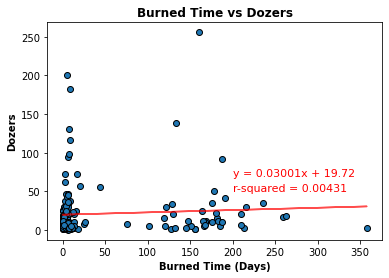

In [31]:
#Discover wheather dozers has relation to burned time
wt_t = water_df.loc[(water_df['Days Burned']>=0) & (water_df['Days Burned']<1000), 'WaterTenders']
wt_days = water_df.loc[(water_df['Days Burned']>=0) & (water_df['Days Burned']<1000), 'Days Burned']

# Define x, y values
wt_x_values = et_days
wt_y_values = eng_t

# Calculate the correlation
wt_correlation = round(st.pearsonr(wt_x_values, wt_y_values)[0],2)
print(f"The correlation between burned time (days) and dozers is {wt_correlation}")

# Calculate linear regression values
(wt_slope, wt_intercept, wt_rvalue, wt_pvalue, wt_stderr) = st.linregress(wt_x_values, wt_y_values) 
                                                                                                   
# Calculate r-squared
wt_r_squared = round(wt_rvalue**2,5)
print(f"The r-squared is: {wt_r_squared}")

# y = mx + b
wt_regress_values = wt_x_values * wt_slope + wt_intercept
wt_line_eq = "y = " + str(round(wt_slope,5)) + "x + " + str(round(wt_intercept,2))

# Gernerate scatter chart with liner regression line, equation of line, r-squared value
plt.scatter(wt_x_values, wt_y_values, edgecolors='black')
plt.plot(wt_x_values, wt_regress_values, color='r', alpha=0.7)

# Plot the Annotation in the graph 
plt.annotate(wt_line_eq,(200,70), fontsize=11, color="red")
plt.annotate(f'r-squared = {wt_r_squared}', (200,50), fontsize=11, color="red")

# Define title and x/y labels
plt.title('Burned Time vs Dozers', fontweight='bold')
plt.xlabel('Burned Time (Days)', fontweight='bold')
plt.ylabel('Dozers', fontweight='bold')

# Save box plot graph to Images folder
plt.savefig('Images/time_water.png')

# Present the box plot chart
plt.show()

# To close pyplot
plt.close()